[toc]
## 热方程的几种差分格式比较
控制方程如下：
$$\frac {\partial u}{\partial t} = \alpha \frac {\partial ^2 u}{\partial x^2} $$
### 1、FTCS格式
首先采用最简单的时间前插，空间中心差分离散控制方程，得到以下离散表达式：
$$u_i^{n+1} = u_i^{n}+\frac{\alpha \Delta t}{\Delta x^2}(u_{i+1}^n-2u_i^n+u_{i-1}^n)$$
**FTCS格式**离散误差时间上一阶精度，空间上二阶精度,数值近似的截断误差为$O（∆t，∆x^2）$由于显示格式的稳定性限制了时空上的离散步长，实际上应用显示格式在计算上要求高。<br>
**初边值条件：**
计算域在$x\in[-1,1]$,扩散系数$\alpha = 1/\pi^2$。初始条件为$u(t=0,x)=-sin(\pi x)$。边界条件是在两端$u=0$。离散步长采用$\Delta x=0.025 ,\Delta t = 0.0025$，计算$t=1$时刻的解。实际上，该解析解可求出为：<br><br>
$$u(t,x) = -e^{-t}sin(\pi x)$$
在$t=1$时刻的误差是：
$$\varepsilon(x_i)=|u_i^{exact}-u_i^{numerical}|$$
基于上述离散形式给出FTCS格式的Julia代码，得到误差L-2范数和最大误差项绝对值如下：<br>
L-2 Norm = 0.00019281858911820228 <br>
Maximum Norm = 0.0002709770126991251 <br>
相关计算结果图示如下
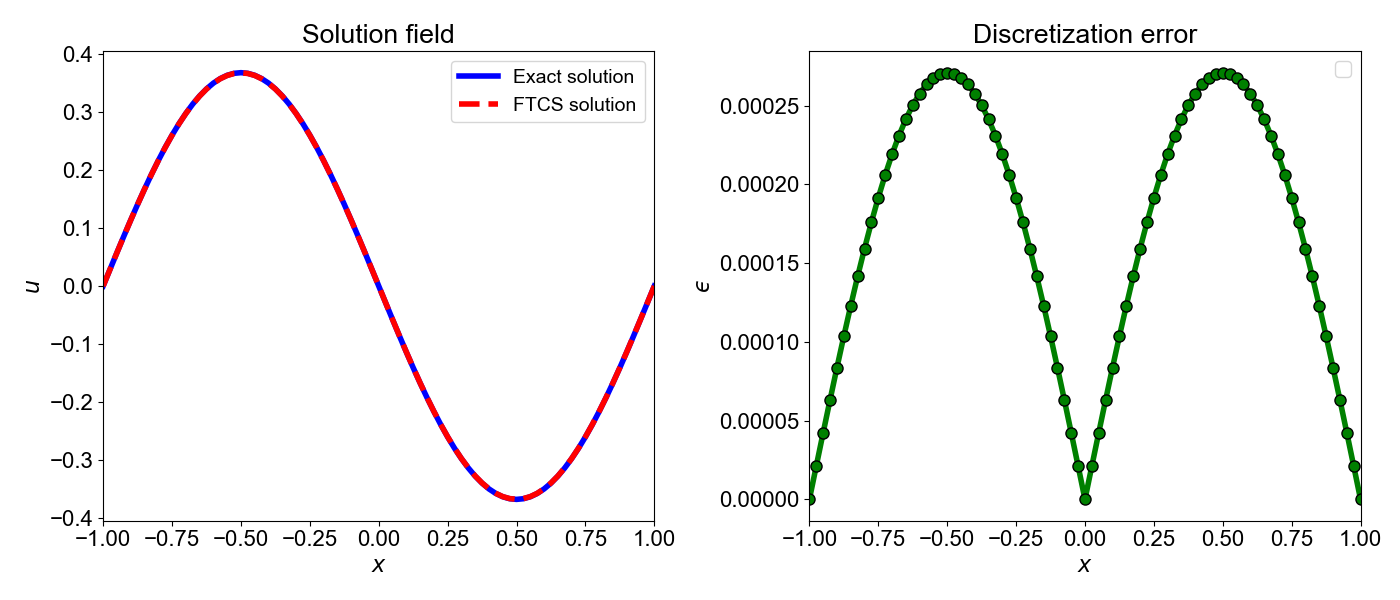
使用FTCS格式和绝对误差图的精确解和数值解的比较如上图所示。可以看到，由于在空间和时间方向上的网格尺寸非常小，我们在精确解和数值解之间获得了非常好的一致性。如果我们使用更大的网格大小，那么我们将看到精度的降低
### 2、Runge-Kutta 数值格式
从FTCS格式中我们知道，要提高精度取决于泰勒项，在时间离散上，我们可以采用龙格库塔法，在两个时间点中增加更多的点， 接下来对时间项采用三阶龙格库塔法离散控制方程,三阶龙格库塔如下：
$$\begin{cases}
u_{n+1} &= u_n+\frac 1 6 h(k_1+4k_2+k_3)\\
k_1 &= f(x_n,u_n)\\
k_2&= f(x_n+\frac 1 2 h,y_n+\frac 1 2 hk_1)\\
k_3&=f(x_n+h,y_n-hk_1+2hk_2)
\end{cases}$$
离散后控制方程如下：
$$u_i^1 = u_i^n+\frac {\alpha \Delta t}{\Delta x^2}(u_{i+1}^n-2u_i^n+u_{i-1}^n)$$
$$u_i^2 = \frac 3 4 u_i^n+\frac 1 4 u_i^1+\frac {\alpha \Delta t}{4\Delta x^2}(u_{i+1}^n-2u_i^n+u_{i-1}^n)$$
$$u_i^{n+1} =\frac 1 3 u_i^n+\frac 2 3 u_i^2 + \frac {2\alpha \Delta t}{3\Delta x^2}(u_{i+1}^n-2u_i^n+u_{i-1}^n)$$
基于上述离散形式给出RK-3格式的Julia代码，得到误差L-2范数和最大误差项绝对值如下：<br>
L-2 Norm = 0.00013456813749787588 <br>
Maximum Norm = 0.00018911491921203005 <br>
![rk3.png](attachment:rk3.png)
由于时间项上采用三阶龙格库塔法，从图上和误差L-2范数都可以看出龙格-库塔数值格式的离散化误差小于FTCS数值格式。
### 3、Crank-Nicolson格式
Crank-Nicolson格式在时间上有着二阶精度，空间上差分在(n+1)时刻展开，时间上仍是向前差分，将得到的离散方程再加上FTCS格式，得到：
$$\frac{u_i^{n+1}-u_i^n}{\Delta t} = \frac \alpha 2 [u_{i+1}^n-2u_i^n+u_{i-1}^n + u_{i+1}^{n+1}-2u_i^{n+1}+u_{i-1}^{n+1}]$$
该差分格式可以看出$(n+1)^{th}$时刻的解取决于$n^{th}$和$(n+1)^{th}$时刻，是隐式数值格式，代数方程组必须通过矩阵来求解。一维情况下是三对角矩阵，可以通过托马斯算法来高效求解。<br>
基于上述离散形式给出RK-3格式的Julia代码，得到误差L-2范数和最大误差项绝对值如下：<br>
L-2 Norm = 0.0001344321088314646 <br>
Maximum Norm = 0.00018892375174345277 <br>
使用Crank-Nicolson格式计算的精确解和数值解的比较以及绝对误差图如图所示。由于截断误差较小，Crank-Nicolson格式的精确解与数值解之间的绝对误差小于FTCS数值格式。


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


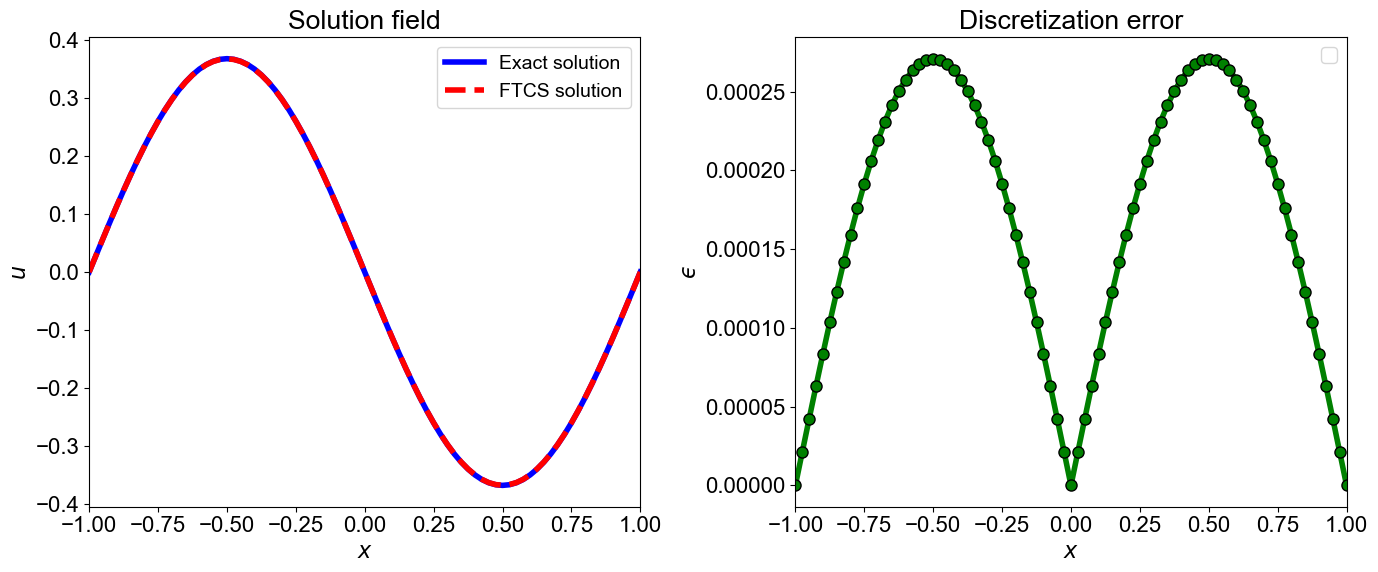

In [8]:
#-----------------------------------------------------------------------------#
# FTCS格式
#-----------------------------------------------------------------------------#
using CPUTime
using Printf
using Plots
#-----------------------------------------------------------------------------#
# 计算误差项的L-2范数
#-----------------------------------------------------------------------------#
function compute_l2norm(nx,r)
    rms = 0.0
    for i = 2:nx
        rms = rms + r[i]^2
    end
    rms = sqrt(rms/((nx-1)))
    return rms
end

x_l = -1.0 
x_r = 1.0
dx = 0.025
nx = Int64((x_r-x_l)/dx)

dt = 0.0025
t = 1.0
nt = Int64(t/dt)

α = 1/(pi*pi)

x = Array{Float64}(undef, nx+1) # 空间离散点
u_e = Array{Float64}(undef, nx+1) # 解析解
un = Array{Float64}(undef, nt+1, nx+1) # 二维数组记录每一个时刻的数值解
error = Array{Float64}(undef, nx+1) # 误差项


for i = 1:nx+1
    x[i] = x_l + dx*(i-1)  # 空间x离散点
    un[1,i] = -sin(pi*x[i]) # initial condition at t=0
    u_e[i] = -exp(-t)*sin(pi*x[i]) # 解析解
end

# 边界条件
un[1,1] = 0.0 
un[1,nx+1] = 0.0

beta = α*dt/(dx*dx)

for k = 2:nt+1
    for i = 2:nx
        un[k,i] = un[k-1,i] + beta*(un[k-1,i+1] -
                                2.0*un[k-1,i] + un[k-1,i-1])
    end
    un[k,1] = 0.0 # boundary condition at x = -1
    un[k,nx+1] = 0.0 # boundary condition at x = 1
end

# 计算误差的L-2范数
u_error = un[nt+1,:] - u_e
rms_error = compute_l2norm(nx,u_error)
max_error = maximum(abs.(u_error)) # 最大误差项的绝对值


# 保存误差相关项
output = open("output.txt", "w");
write(output, "Error details: \n");
write(output, "L-2 Norm = ", string(rms_error), " \n");
write(output, "Maximum Norm = ", string(max_error), " \n");

# 储存所有的计算量
field_final = open("field_final.csv", "w");
write(field_final, "x"," ", "ue", " ", "un", " ", "uerror" ," \n")

for i = 1:nx+1
    write(field_final, @sprintf("%.16f",x[i])," ",@sprintf("%.16f", u_e[i])," ",
          @sprintf("%.16f", un[nt+1,i])," ",@sprintf("%.16f", u_error[i])," \n")
end

close(field_final)
close(output);

# 绘图
using CSV
using PyPlot
using DataFrames
rc("font", family="Arial", size=16.0)


final_field = CSV.read("field_final.csv",DataFrame)
x = convert(Array,final_field[:,1])

u_e = convert(Array,final_field[:,2])
u_n = convert(Array,final_field[:,3])
u_error = convert(Array,final_field[:,4])

u = Array{Float64}(undef, length(u_e), 2)
u[:,1] = u_e
u[:,2] = u_n

for i = 1:Int64(length(u_error))
    u_error[i] = abs(u_error[i])
end

fig = figure("FTCS", figsize=(14,6));
ax1 = fig[:add_subplot](1,2,1);
ax2 = fig[:add_subplot](1,2,2);

ax1.plot(x, u_e, lw=4, ls = "-", color="b", label="Exact solution")
ax1.plot(x, u_n, lw=4, ls = "--", color="r", label="FTCS solution")
ax1.set_xlabel("\$x\$")
ax1.set_ylabel("\$u\$")
ax1.set_title("Solution field")
ax1.set_xlim(-1,1)
ax1.legend(fontsize=14, loc=0)

ax2.plot(x, u_error, marker = "o", markeredgecolor="k",
        markersize=8, color="g", lw=4)
ax2.set_xlabel("\$x\$")
ax2.set_ylabel("\$ϵ\$")
ax2.set_title("Discretization error")
ax2.set_xlim(-1,1)
ax2.legend(fontsize=14, loc=0)

# plt[:subplot](ax1);
# plt[:subplot](ax2);

fig.tight_layout()
fig.savefig("ftcs.png")


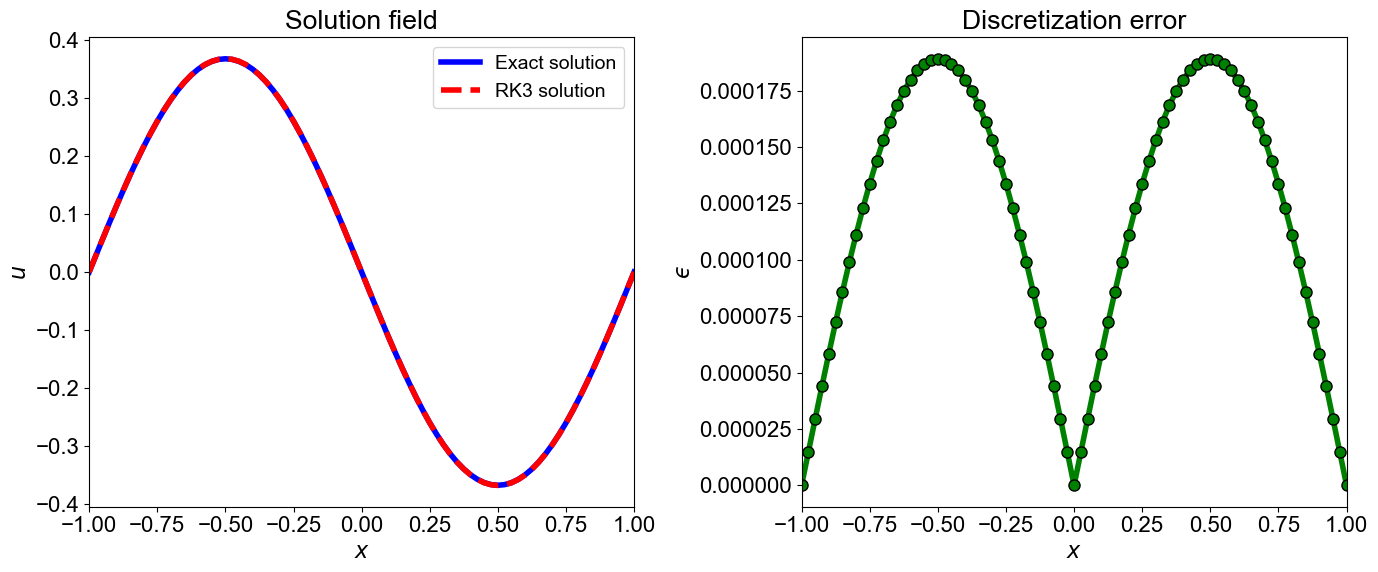

In [14]:
#-----------------------------------------------------------------------------#
# RK-3格式
#-----------------------------------------------------------------------------#
using CPUTime
using Printf
using Plots
#-----------------------------------------------------------------------------#
# 计算误差项的L-2范数
#-----------------------------------------------------------------------------#
function compute_l2norm(nx,r)
    rms = 0.0
    for i = 2:nx
        rms = rms + r[i]^2
    end
    rms = sqrt(rms/((nx-1)))
    return rms
end

#-----------------------------------------------------------------------------#
# Compute numerical solution
#   - Time integration using Runge-Kutta third order
#-----------------------------------------------------------------------------#
function numerical(nx,nt,dx,dt,x,u,α)
    un = Array{Float64}(undef, nx+1) 
    ut = Array{Float64}(undef, nx+1) 
    r = Array{Float64}(undef, nx)

    k = 1 
    

    for i = 1:nx+1
        un[i] = -sin(pi*x[i])
        u[i,k] = un[i] 
    end

    un[1] = 0.0
    un[nx+1] = 0.0

    ut[1] = 0.0
    ut[nx+1] = 0.0

    for j = 2:nt+1
        rhs(nx,dx,un,r,α)

        for i = 2:nx
            ut[i] = un[i] + dt*r[i]
        end

        rhs(nx,dx,ut,r,α)

        for i = 2:nx
            ut[i] = 0.75*un[i] + 0.25*ut[i] + 0.25*dt*r[i]
        end

        rhs(nx,dx,ut,r,α)

        for i = 2:nx
            un[i] = (1.0/3.0)*un[i] + (2.0/3.0)*ut[i] + (2.0/3.0)*dt*r[i]
        end

        k = k+1
        u[:,k] = un[:]
    end
end

function rhs(nx,dx,u,r,α)
    for i = 2:nx
        r[i] = α*(u[i+1] - 2.0*u[i] + u[i-1])/(dx*dx)
    end
end

#---------------------------------------------------------------------------#
# main program
#---------------------------------------------------------------------------#
x_l = -1.0
x_r = 1.0
dx = 0.025
nx = Int64((x_r-x_l)/dx)

dt = 0.0025
t = 1.0
nt = Int64(t/dt)

α = 1/(pi*pi) # 扩散率

u = Array{Float64}(undef, nx+1, nt+1)
x = Array{Float64}(undef, nx+1)
u_e = Array{Float64}(undef, nx+1)
error = Array{Float64}(undef, nx+1)

for i = 1:nx+1
    x[i] = x_l + dx*(i-1) 
    u_e[i] = -exp(-t)*sin(pi*x[i]) 
end

numerical(nx,nt,dx,dt,x,u,α)

u_error = zeros(nx+1)
u_error = u[:,nt+1] - u_e
rms_error = compute_l2norm(nx, u_error)
max_error = maximum(abs.(u_error))

# create output file for L2-norm
output = open("output2.txt", "w");
write(output, "Error details: \n");
write(output, "L-2 Norm = ", string(rms_error), " \n");
write(output, "Maximum Norm = ", string(max_error), " \n");

# create text file for final field
field_final = open("field_final2.csv", "w");
write(field_final, "x"," ", "ue", " ", "un", " ", "uerror" ," \n")

for i = 1:nx+1
    write(field_final, @sprintf("%.16f",x[i])," ",@sprintf("%.16f", u_e[i])," ",
          @sprintf("%.16f", u[i,nt+1])," ",@sprintf("%.16f", u_error[i])," \n")
end

close(field_final)
close(output);


# 绘图
using DataFrames
using CSV
using PyPlot
rc("font", family="Arial", size=16.0)


final_field = CSV.read("field_final2.csv",DataFrame)

x = convert(Array,final_field[:,1])

u_e = convert(Array,final_field[:,2])
u_n = convert(Array,final_field[:,3])
u_error = convert(Array,final_field[:,4])

u = Array{Float64}(undef, length(u_e), 2)
u[:,1] = u_e
u[:,2] = u_n

for i = 1:Int64(length(u_error))
    u_error[i] = abs(u_error[i])
end

fig = figure("An example", figsize=(14,6));
ax1 = fig[:add_subplot](1,2,1);
ax2 = fig[:add_subplot](1,2,2);

ax1.plot(x, u_e, lw=4, ls = "-", color="b", label="Exact solution")
ax1.plot(x, u_n, lw=4, ls = "--", color="r", label="RK3 solution")
ax1.set_xlabel("\$x\$")
ax1.set_ylabel("\$u\$")
ax1.set_title("Solution field")
ax1.set_xlim(-1,1)
ax1.legend(fontsize=14, loc=0)

ax2.plot(x, u_error, marker = "o", markeredgecolor="k",
        markersize=8, color="g", lw=4)
ax2.set_xlabel("\$x\$")
ax2.set_ylabel("\$ϵ\$")
ax2.set_title("Discretization error")
ax2.set_xlim(-1,1)
#ax2.legend(fontsize=14, loc=0)

# plt[:subplot](ax1);
# plt[:subplot](ax2);

fig.tight_layout()
fig.savefig("rk3.png")

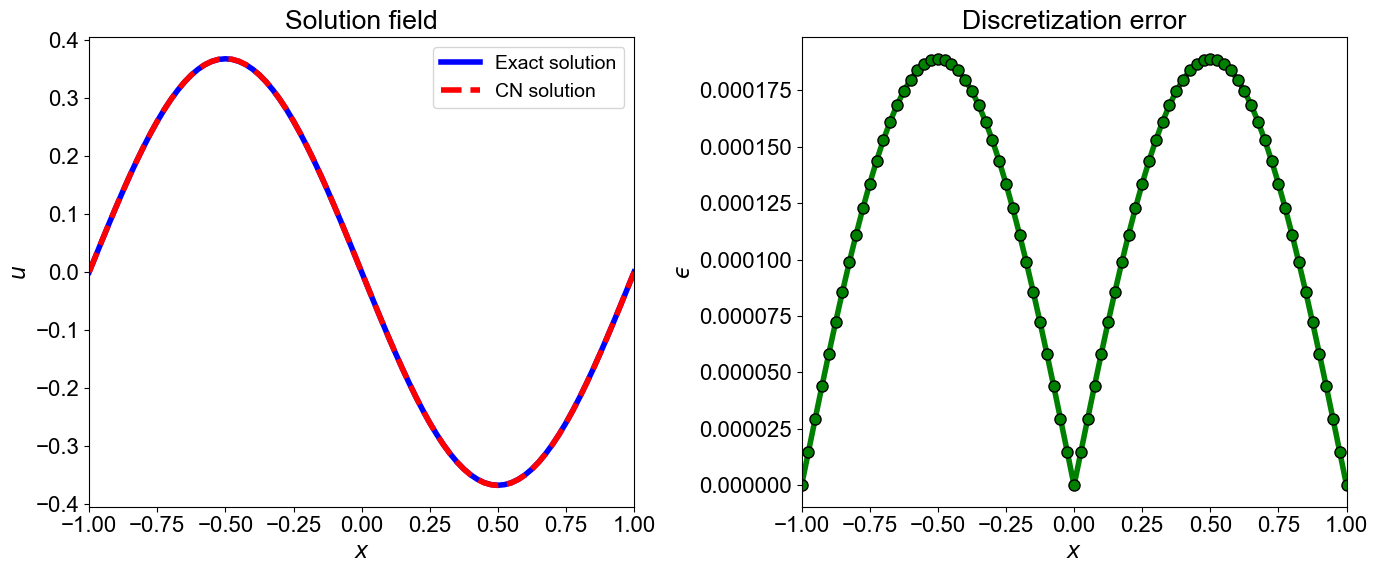

In [17]:
using CPUTime
using Printf
using Plots

function compute_l2norm(nx,r)
    rms = 0.0
    for i = 2:nx
        rms = rms + r[i]^2
    end

    rms = sqrt(rms/((nx-1)))
    return rms
end

#-----------------------------------------------------------------------------#
# Solution to tridigonal system using Thomas algorithm (part of ctdms)
#-----------------------------------------------------------------------------#
function tdms(a,b,c,r,x,s,e)
    gam = Array{Float64}(undef, e)
    bet = b[s]
    x[s] = r[s]/bet

    for i = s+1:e
        gam[i] = c[i-1]/bet
        bet = b[i] - a[i]*gam[i]
        x[i] = (r[i] - a[i]*x[i-1])/bet
    end

    for i = e-1:-1:s
        x[i] = x[i] - gam[i+1]*x[i+1]
    end
    return x
end

#-----------------------------------------------------------------------------#
# Solution to tridigonal system using Thomas algorithm
#-----------------------------------------------------------------------------#
function tdma(a,b,c,r,s,e)
    up = Array{Float64}(undef, nx+1)
    for i = s+1:e+1
        b[i] = b[i] - a[i]*(c[i-1]/b[i-1])
        r[i] = r[i] - a[i]*(r[i-1]/b[i-1])
    end

    up[e+1] = r[e+1]/b[e+1]

    for i = e:-1:s
        up[i] = (r[i] - c[i]*up[i+1])/b[i]
    end
    return up
end

x_l = -1.0
x_r = 1.0
dx = 0.025
nx = Int64((x_r-x_l)/dx)

dt = 0.0025
t = 1.0
nt = Int64(t/dt)

α = 1/(pi*pi)

x = Array{Float64}(undef, nx+1)
tlist = Array{Float64}(undef, nt+1)
u_e = Array{Float64}(undef, nx+1)
u_n = Array{Float64}(undef, nt+1, nx+1)
a = Array{Float64}(undef, nx+1)
b = Array{Float64}(undef, nx+1)
c = Array{Float64}(undef, nx+1)
r = Array{Float64}(undef, nx+1)
p = Array{Float64}(undef, nx+1)

for i = 1:nx+1
    x[i] = x_l + dx*(i-1)  # location of each grid point
    u_n[1,i] = -sin(pi*x[i]) # initial condition @ t=0
    u_e[i] = -exp(-t)*sin(pi*x[i]) # initial condition @ t=0
end

u_n[1,1] = 0.0
u_n[1,nx+1] = 0.0

α1 = α*dt/(2.0*dx*dx)

s = 1
e = nx

for k = 2:nt+1
    i = 1
    a[i] = 0.0
    b[i] = 1.0
    c[i] = 0.0
    for i = 2:nx
        a[i] = -α1
        b[i] = 1.0+2.0*α1
        c[i] = -α1
    end
    i = nx+1
    a[i] = 0.0
    b[i] = 1.0
    c[i] = 0.0
    for i = 2:nx
        r[i] = α1*u_n[k-1,i+1] + (1.0-2.0*α1)*u_n[k-1,i] + α1*u_n[k-1,i-1]
    end
    r[1] = 0.0
    r[nx+1] = 0.0
    tdms(a,b,c,r,p,s,e)
    u_n[k,:] = p
    #tdms(a,b,c,r,u_n[k,:],s,e)
end

# compute L2 norm of the error
u_error = u_n[nt+1,:] - u_e
rms_error = compute_l2norm(nx,u_error)
max_error = maximum(abs.(u_error))

# create output file for L2-norm
output = open("output3.txt", "w");
write(output, "Error details: \n");
write(output, "L-2 Norm = ", string(rms_error), " \n");
write(output, "Maximum Norm = ", string(max_error), " \n");

# create text file for final field
field_final = open("field_final3.csv", "w");
write(field_final, "x"," ", "ue", " ", "un", " ", "uerror" ," \n")

for i = 1:nx+1
    write(field_final, @sprintf("%.16f",x[i])," ",@sprintf("%.16f", u_e[i])," ",
          @sprintf("%.16f", u_n[nt+1,i])," ",@sprintf("%.16f", u_error[i])," \n")
end

close(field_final)
close(output);

#----------------------------------------------------#
# 绘图
#----------------------------------------------------#
using CSV
using PyPlot
using DataFrames
rc("font", family="Arial", size=16.0)


final_field = CSV.read("field_final3.csv",DataFrame)#, datarow = 2, type=Float64)

x = convert(Array,final_field[:,1])

u_e = convert(Array,final_field[:,2])
u_n = convert(Array,final_field[:,3])
u_error = convert(Array,final_field[:,4])

u = Array{Float64}(undef, length(u_e), 2)
u[:,1] = u_e
u[:,2] = u_n

for i = 1:Int64(length(u_error))
    u_error[i] = abs(u_error[i])
end

fig = figure("An example", figsize=(14,6));
ax1 = fig[:add_subplot](1,2,1);
ax2 = fig[:add_subplot](1,2,2);

ax1.plot(x, u_e, lw=4, ls = "-", color="b", label="Exact solution")
ax1.plot(x, u_n, lw=4, ls = "--", color="r", label="CN solution")
ax1.set_xlabel("\$x\$")
ax1.set_ylabel("\$u\$")
ax1.set_title("Solution field")
ax1.set_xlim(-1,1)
ax1.legend(fontsize=14, loc=0)

ax2.plot(x, u_error, marker = "o", markeredgecolor="k",
        markersize=8, color="g", lw=4)
ax2.set_xlabel("\$x\$")
ax2.set_ylabel("\$ϵ\$")
ax2.set_title("Discretization error")
ax2.set_xlim(-1,1)
#ax2.legend(fontsize=14, loc=0)

# plt[:subplot](ax1);
# plt[:subplot](ax2);

fig.tight_layout()
fig.savefig("cn.png")


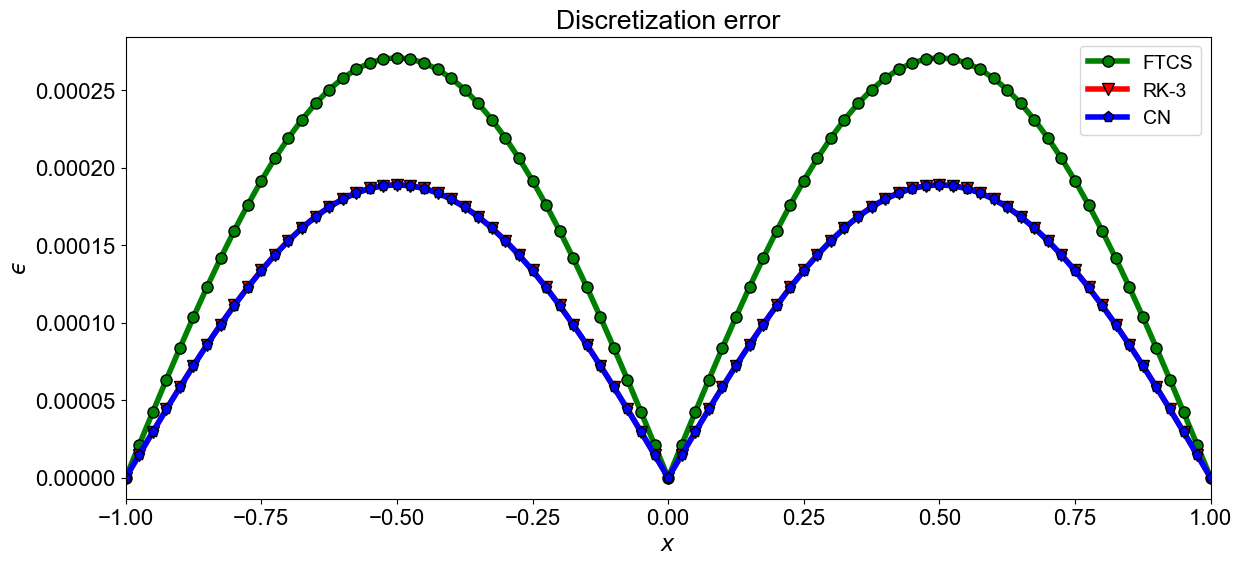

In [24]:
using DataFrames
using CSV
using PyPlot
rc("font", family="Arial", size=16.0)


final_field = CSV.read("field_final.csv",DataFrame)
final_field2 = CSV.read("field_final2.csv",DataFrame)
final_field3 = CSV.read("field_final3.csv",DataFrame)

x = convert(Array,final_field[:,1])
u_error = convert(Array,final_field[:,4])
u_error2 = convert(Array,final_field2[:,4])
u_error3 = convert(Array,final_field3[:,4])

for i = 1:Int64(length(u_error))
    u_error[i] = abs(u_error[i])
end
for i = 1:Int64(length(u_error2))
    u_error2[i] = abs(u_error2[i])
end
for i = 1:Int64(length(u_error3))
    u_error3[i] = abs(u_error3[i])
end

fig = figure("An example", figsize=(14,6));
ax2 = fig[:add_subplot](1,1,1);


ax2.plot(x, u_error, marker = "o", markeredgecolor="k",
        markersize=8, color="g", lw=4,label="FTCS")
ax2.plot(x, u_error2, marker = "v", markeredgecolor="k",
        markersize=8, color="r", lw=4,label="RK-3")
ax2.plot(x, u_error3, marker = "p", markeredgecolor="k",
        markersize=8, color="b", lw=4,label="CN")
ax2.set_xlabel("\$x\$")
ax2.set_ylabel("\$ϵ\$")
ax2.set_title("Discretization error")
ax2.set_xlim(-1,1)
ax2.legend(fontsize=14, loc=0)

# plt[:subplot](ax1);
# plt[:subplot](ax2);

fig.savefig("error_all.png")